# Plot EEG from different dipole orientations

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from lfpykit.eegmegcalc import FourSphereVolumeConductor
from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from ECSbook_simcode.neural_simulations import return_equidistal_xyz
from ECSbook_simcode.plotting_convention import mark_subplots, simplify_axes

head_colors = ["#ffb380", "#74abff", "#b3b3b3", "#c87137"]

radii = [89000., 90000., 95000., 100000.]  # (µm)
sigmas = [0.276, 1.65, 0.01, 0.465]  # (S/m)

cdm_mag = 1e7
p_rad = np.array([0, 0, cdm_mag])
p_tan = np.array([cdm_mag, 0, 0])

# Manually constructed illustrative combinations of different dipoles 
# at different locations 
ps = [[p_rad, p_rad, p_rad, p_rad],
      [p_rad, -p_rad, p_rad, -p_rad],
      [p_tan, p_tan, p_tan, p_tan],
      [p_tan, p_tan, p_rad, p_rad],
      [p_tan, p_tan, -p_tan, -p_tan]]

loc_z = radii[0] - 1500
p_xs = [[-750, -250, 250, 750],
        [-750, -250, 250, 750],
        [0, 0, 0, 0],
        [-500, -500, 250, 750],
        [-750, -750, 750, 750]]

p_ys = [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]

p_zs = [[loc_z, loc_z, loc_z, loc_z],
        [loc_z, loc_z, loc_z, loc_z],
        [loc_z + 500, loc_z, loc_z - 500, loc_z - 1000],
        [loc_z + 500, loc_z, loc_z - 500, loc_z - 500],
        [loc_z, loc_z - 500, loc_z, loc_z - 500]]

num_cases = len(p_xs)
num_dipoles = len(p_xs[0])

x_, y_, z_ = return_equidistal_xyz(1000, radii[-1] - 1) 

upper_idxs = np.where(z_ > 0)
x_ = x_[upper_idxs]
y_ = y_[upper_idxs]
z_ = z_[upper_idxs]

num_elecs = len(x_)
r_elecs = np.vstack((x_, y_, z_)).T
        

In [2]:
sphere_model = FourSphereVolumeConductor(r_elecs, radii, sigmas)
eeg = np.zeros((num_cases, num_elecs))

for c_idx in range(num_cases):
    for p_idx in range(num_dipoles):
        dipole_loc = np.array([p_xs[c_idx][p_idx], 
                               p_ys[c_idx][p_idx], 
                               p_zs[c_idx][p_idx]])
        p = ps[c_idx][p_idx]
        M = sphere_model.get_transformation_matrix(dipole_loc)  
        eeg[c_idx] += 1e3 * M @ p # (uV)


[21.43609878  0.16064462  8.5037972  13.28028681  0.52600904]


<ipython-input-8-111523a306b6>:75: UserWarning: No contour levels were found within the data range.
  ax_eeg.tricontour(x_, y_, eeg[c_idx], levels, cmap="PRGn",


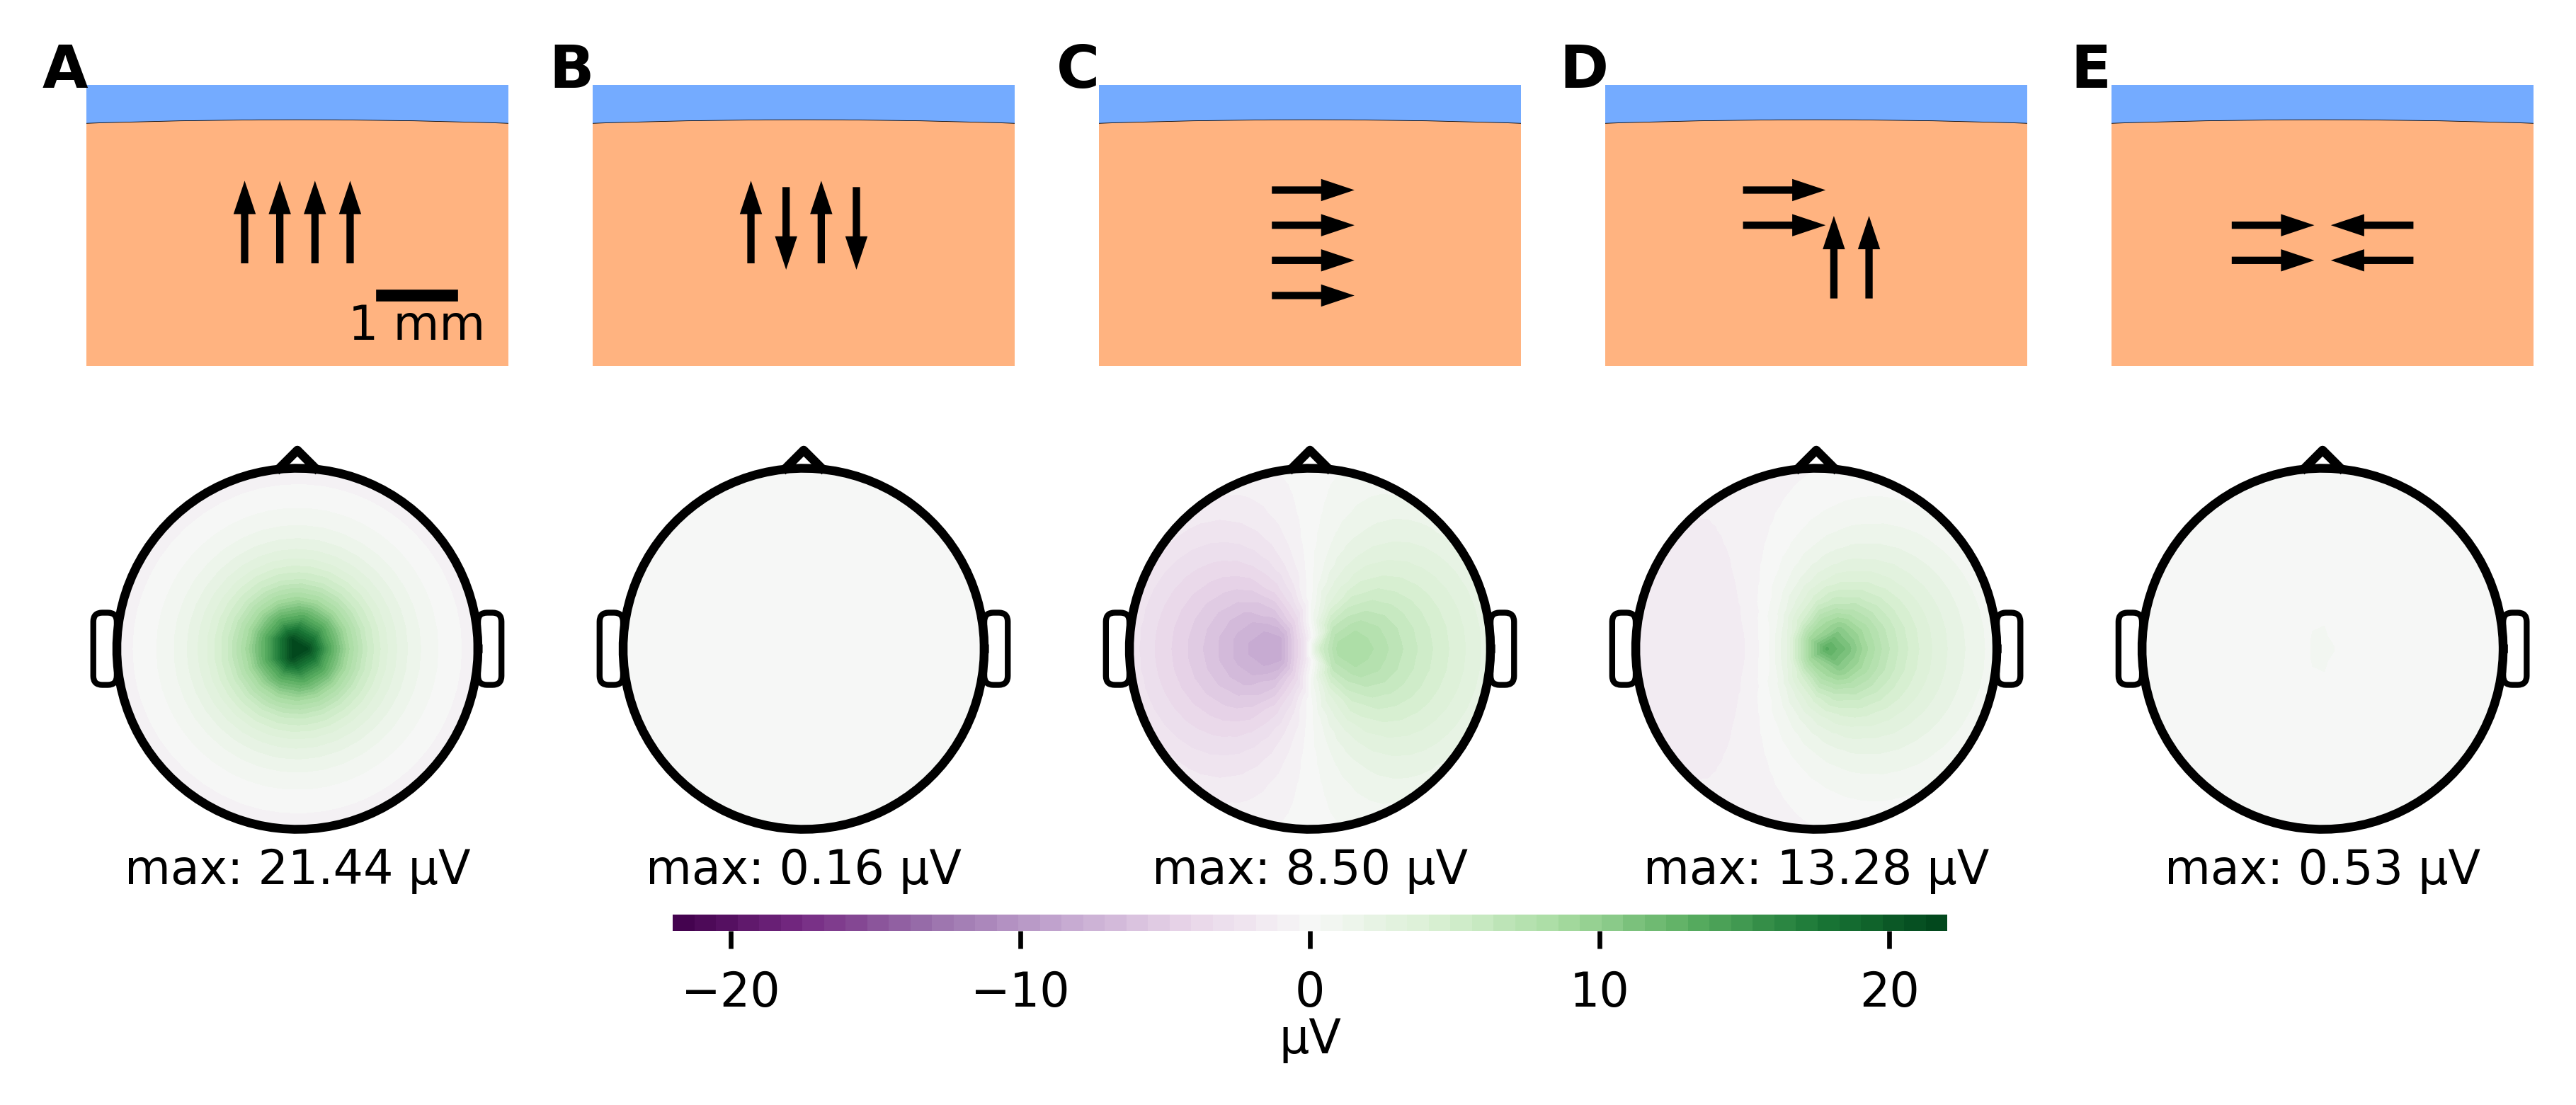

In [8]:
def plot_four_sphere_model(ax, radii):
    ax.add_patch(plt.Circle((0, 0), radius=radii[1],
                               color=head_colors[1],
                               fill=True, ec='k', lw=.1))
    ax.add_patch(plt.Circle((0, 0), radius=radii[0],
                               color=head_colors[0],
                               fill=True, ec='k', lw=.1))

def plot_head_outline(ax, radius):
    circle_npts = 100
    head_x = radius * np.cos(np.linspace(0, 2 * np.pi, circle_npts))
    head_y = radius * np.sin(np.linspace(0, 2 * np.pi, circle_npts))
    patches = []
    right_ear = mpatches.FancyBboxPatch([radius + 5000, -15000], 3000, 30000,
        boxstyle=mpatches.BoxStyle("Round", pad=5000))
    patches.append(right_ear)

    left_ear = mpatches.FancyBboxPatch([-radius - 8000, -15000], 3000, 30000,
        boxstyle=mpatches.BoxStyle("Round", pad=5000))
    patches.append(left_ear)

    collection = PatchCollection(patches, facecolor='none', edgecolor='k', alpha=1.0)
    ax.add_collection(collection)
    ax.plot(head_x, head_y, 'k')
    ax.plot([radius])

    ax.plot([-10000, 0, 10000], [radius, radius + 10000, radius], 'k')

plt.close("all")
fig = plt.figure()
fig.subplots_adjust(bottom=0.2, right=0.98, left=0.02, 
                    top=0.99, wspace=.2, hspace=0.02)

print(np.max(np.abs(eeg), axis=1))
vmax = 22

levels = np.linspace(-np.ceil(vmax), np.ceil(vmax), 60)

ax_geom_dict = dict(frameon=False, aspect=1,
                     xticks=[], yticks=[],
                     xlim=[-3000, 3000],
                     ylim=[radii[0] - 3500, radii[0] + 500])

ax_eeg_dict = dict(frameon=False, aspect=1,
                   xticks=[], yticks=[],
                   xlim=[-115000, 115000],
                   ylim=[-115000, 115000])

arrow_length = 1000
axes_geom = []
for c_idx in range(num_cases):
    ax_geom = fig.add_subplot(2, num_cases, c_idx + 1, **ax_geom_dict)
    ax_eeg = fig.add_subplot(2, num_cases, c_idx + 1 + num_cases, 
                             **ax_eeg_dict)
    axes_geom.append(ax_geom)
    ax_eeg.text(0, -130000, "max: {:1.2f} µV".format(np.max(np.abs(eeg[c_idx]))),
               ha='center')
    plot_four_sphere_model(ax_geom, radii)
    plot_head_outline(ax_eeg, radii[-1])
    
    for p_idx in range(num_dipoles):
        x0 = p_xs[c_idx][p_idx]
        z0 = p_zs[c_idx][p_idx]
        px = ps[c_idx][p_idx][0]
        pz = ps[c_idx][p_idx][2]
        dx = arrow_length * px / np.abs(px + 1e-1)
        dz = arrow_length * pz  / np.abs(pz + 1e-1)
        
        ax_geom.arrow(x0 - dx/2, z0 - dz/2, dx, dz, width=20, 
                      length_includes_head=True, 
                      head_width=200, fc='k')
        
    img = ax_eeg.tricontourf(x_, y_, eeg[c_idx], levels, cmap="PRGn", 
                             vmax=vmax, vmin=-vmax)
    ax_eeg.tricontour(x_, y_, eeg[c_idx], levels, cmap="PRGn", 
                             vmax=vmax, vmin=-vmax, zorder=-1)
    
    if c_idx == 0:
        ax_geom.plot([1200, 2200], [radii[0]-2500, radii[0]-2500], lw=2, c='k')
        ax_geom.text(1700, radii[0] - 2600, "1 mm", va='top', ha="center")

mark_subplots(axes_geom, ypos=1.05, xpos=-0.05)

cax = fig.add_axes([0.25, 0.13, 0.5, 0.015], frameon=False)
plt.colorbar(img, cax=cax, ticks=[-20, -10, 0, 10, 20], label="µV", orientation="horizontal")

plt.savefig("eeg_dipole_orientation_2.pdf")